In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import kde
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.special import erfinv
from matplotlib.colors import LogNorm

plotId = 0
smallFiles = False
outTag='DataSimCh'

#settings
plt.style.use('fast')
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.linewidth'] = 3.0
matplotlib.rcParams['hist.bins'] = 'auto'
matplotlib.rcParams['text.usetex'] = 'true'
#matplotlib.rcParams['text.latex.unicode']= 'true' #deprecated from Matplotlib 3.0
matplotlib.rcParams['image.cmap'] = 'RdYlBu_r' #'hot'
#print(matplotlib.rcParams)

#Common offset for ACP80 runs
gonio_zero = 1570840.0/1000. #mrad
thetaInx_bias = 0.005  #mrad : difference between nominal '0' and crystal plane '0'

#useful labels
d0xL=r"$d_0^{x}$ [mm]"
d0yL=r"$d_0^{y}$ [mm]"
tInXL=r"$\theta_{in}^{x}$ [mrad]"
tInYL=r"$\theta_{in}^{y}$ [mrad]"
tOutXL=r"$\theta_{out}^{x}$ [mrad]"
tOutYL=r"$\theta_{out}^{y}$ [mrad]"
dtL=r"$\Delta\theta_{(out-in)}$ [mrad]"

#useful binning/range
d0xR=[-2.,2.]
d0yR=[-2.,2.]
tInXR=[-0.1,0.1]
tInYR=[-0.1,0.1]
tOutXR=[-0.2,0.2]
tOutXGonioR=[-0.15-gonio_zero,+0.15-gonio_zero]
tOutYR=[-0.1,0.1]
#
nBd0=20
nBth=20
nBd0F=50
nBthF=50

colorsP=['Reds','Blues','Greens','Oranges','Purples','Greys','viridis','Reds','Blues','Greens','Oranges','Purples','Greys']
colors=['r','b','g','orange','purple','grey','teal','r','b','g','orange','purple','grey']
print("Hello world!")
folder= "../BigDataFiles/"
inputFiles=[]
inputFiles.append(folder+"ACP80_0_flt.dat")
#inputFiles.append(folder+"ACP80_min50_flt.dat")
#inputFiles.append(folder+"ACP80_min70_flt.dat")
#inputFiles.append(folder+"ACP80_min90_flt.dat")
#inputFiles.append(folder+"ACP80_plus10_flt.dat")
#inputFiles.append(folder+"ACP80_plus50_flt.dat")
#inputFiles.append(folder+"ACP80_6534.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_0_NoCryst_N10000.dat")
inputFiles.append(folder+"mUA9SimSqEne180_0_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min10_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min20_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min30_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min40_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min50_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min60_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min70_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min80_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_min90_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_plus10_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_plus20_N10000.dat")
#inputFiles.append(folder+"mUA9SimSqEne180_plus40_N10000.dat")

print(inputFiles)
inFileLabels=[]
for iF in inputFiles:
    inFileLabels.append(iF.split("/")[-1].split(".")[0].replace("_"," "))
print(inFileLabels)
angles=[]
for iF in inputFiles:
    angle = iF.split("/")[-1].split(".")[0].split("_")[1].replace("min","-").replace("plus","")
    if angle == '6534': angle='20'
    angles.append(int(angle))
print(angles)

cols=["gonio_angle","d0_x","d0_y","thetaIn_x","thetaOut_x","thetaIn_y","thetaOut_y","unknown1","unknown2"]

Hello world!
['../BigDataFiles/ACP80_0_flt.dat', '../BigDataFiles/mUA9SimSqEne180_0_N10000.dat']
['ACP80 0 flt', 'mUA9SimSqEne180 0 N10000']
[0, 0]


In [2]:
def emittanceRMS(x,y):
    rmsX = np.std(x)
    rmsY = np.std(y)
    #print(np.corrcoef(x,y))
    det = np.linalg.det(np.corrcoef(x,y))
    #print(rmsX,rmsY,det)
    return rmsX*rmsY*math.sqrt(det)

def plot2D(ax,x,y,xlabel,ylabel,bins,rng,cmap):
    plot= ax.hist2d(x, y, bins=bins,range=rng,  cmap=cmap)
    ax.set_xlabel(xlabel, fontsize='20')
    ax.set_ylabel(ylabel, fontsize='20')
    return ax

def plot1D(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None,weights=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    if log: ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng)
    ax.legend(loc= "best")
    ax.grid(True)
    return ax

def plot1DNorm(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng, density=True)
    ax.legend(loc= "lower right")
    ax.grid(True)
    return ax

In [3]:
datasetsI = []
for iF in inputFiles:
    datasetI = pd.read_csv(iF,header=None,names=cols)
    datasetI["gonio_angle"]=datasetI["gonio_angle"]/1000.
    datasetI["thetaIn_x"]=datasetI["thetaIn_x"]*1000.
    datasetI["thetaOut_x"]=datasetI["thetaOut_x"]*1000.
    datasetI["thetaIn_y"]=datasetI["thetaIn_y"]*1000.
    datasetI["thetaOut_y"]=datasetI["thetaOut_y"]*1000.
    datasetI["deltaTheta"] = datasetI["thetaOut_x"]-datasetI["thetaIn_x"]
    datasetI["deltaGonio"] = datasetI["gonio_angle"]-gonio_zero
    datasetI["weight"] = 1.
    if iF==folder+"ACP80_min70_flt.dat":
        datasetI["deltaGonio"] = datasetI["deltaGonio"]-3252.2186 #3252.0786
    if "mUA9Sim" in iF:
        print("This is a MC simulated sample.")
        datasetI["deltaGonio"] = -1*datasetI["gonio_angle"] #no offset in this case
        
    print(datasetI.iloc[0,:])
    datasetsI.append(datasetI)

gonio_angle    1570.840000
d0_x             -0.118649
d0_y             -0.246366
thetaIn_x        -0.007750
thetaOut_x        0.049916
thetaIn_y         0.018783
thetaOut_y        0.039124
unknown1          0.000000
unknown2          0.000000
deltaTheta        0.057666
deltaGonio        0.000000
weight            1.000000
Name: 0, dtype: float64
This is a MC simulated sample.
gonio_angle    0.000000
d0_x          -1.045436
d0_y          -0.510995
thetaIn_x     -0.022406
thetaOut_x    -0.024988
thetaIn_y      0.035199
thetaOut_y     0.032114
unknown1       0.000000
unknown2       0.000000
deltaTheta    -0.002582
deltaGonio    -0.000000
weight         1.000000
Name: 0, dtype: float64


In [4]:
datasets = []
for ds in datasetsI:
    #pass the initial dataset to the one you'll manipulate
    dataset = ds
    # append to list
    datasets.append(dataset)
print("Analyzing %d datasets"%len(datasets))
nds=len(datasets)

Analyzing 2 datasets


## Now we make some plot to have a first glance at the distribution

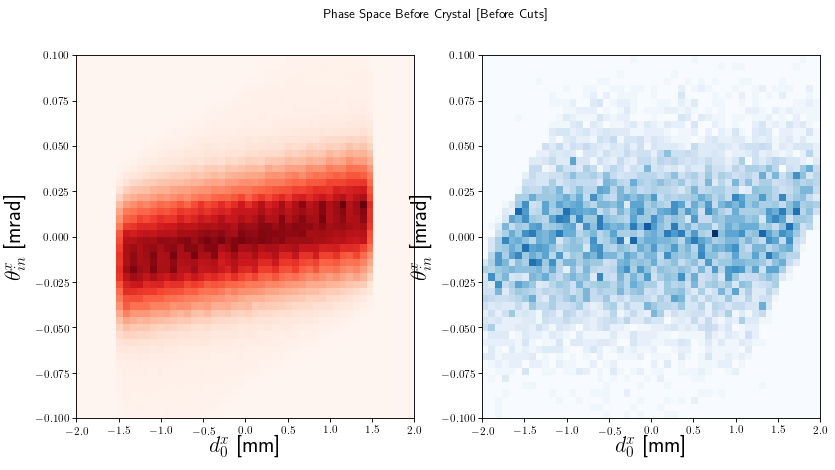

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Phase Space Before Crystal [Before Cuts]")
for i in range(nds):
    plot2D(axes[i],
           datasets[i]["d0_x"],
           datasets[i]["thetaIn_x"],
           d0xL,
           tInXL,
           (nBd0F,nBthF),
           [d0xR,tInXR],
           colorsP[i]
          )
plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Let's have a look at particle deflection due to the crystal

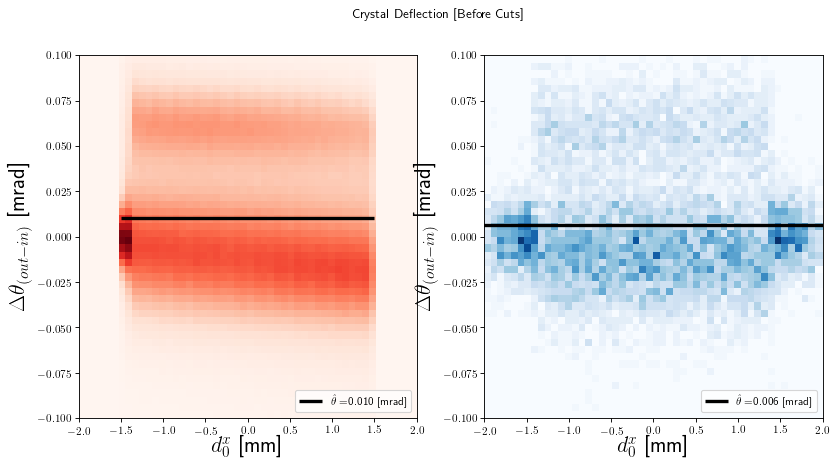

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Crystal Deflection [Before Cuts]")
plots = []
medias = []
for i in range(nds):
    plots.append(
                plot2D(axes[i],
                datasets[i]["d0_x"],
                datasets[i]["deltaTheta"],
                d0xL,
                dtL,
                (nBd0F,nBthF),
                [d0xR,[-0.1,0.1]],
                colorsP[i]
                )
                )
    medias.append(np.mean(datasets[i]["deltaTheta"]))
    plots[-1].hlines(medias[-1], 
                     np.min(datasets[i]["d0_x"]), 
                     np.max(datasets[i]["d0_x"]), 
                     label=(r"$\hat\theta=${:.3f} [mrad]".format(medias[-1]))
                    )
    plots[-1].legend(loc= "lower right")
plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

### Let's add some cuts!
    - In the incoming angle in order to choose particles that are going to be channeled (Crit. angle for this 180GeV case is +-15urad: general formula is sqrt(4/E[GeV])*100urad )
    - In x (raw cut on data was +- 1.5mm), we can reduce the data sample to those within +- 1mm
    - In y since we want to avoid problems related with the crystal torsion   
## We have now only particles entering within +-ThetaCrit
    

In [7]:
applyCut = True
applyWeight = False
max_d0x = 1.
max_d0y = 1.5
max_thetaInx = 0.015 #15urad

if applyCut:
    for i in range(len(datasets)):
        dataset = datasets[i]
        dataset = dataset[abs(dataset.d0_x)<max_d0x]
        dataset = dataset[abs(dataset.d0_y)<max_d0y]
        dataset = dataset[abs(dataset.thetaIn_x+thetaInx_bias)<max_thetaInx]
        datasets[i] = dataset

## Let's look again at the phase space after these cuts

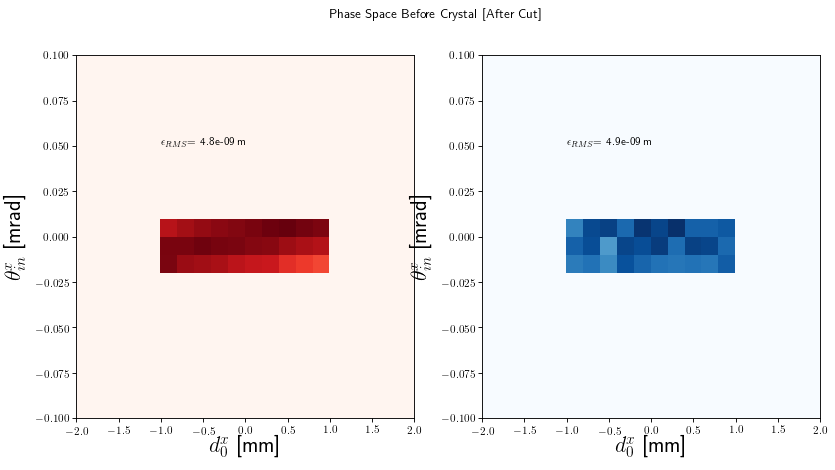

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Phase Space Before Crystal [After Cut]")
plots=[]
for i in range(nds):
    plots.append(plot2D(axes[i],datasets[i]["d0_x"],datasets[i]["thetaIn_x"],d0xL,tInXL,
           (nBd0,nBth),[d0xR,tInXR],colorsP[i]))
    plots[-1].text(-1.,.05,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(datasets[i]["d0_x"],datasets[i]["thetaIn_x"])))

plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Let's have a look at some plots to better understand the distribution after the cuts

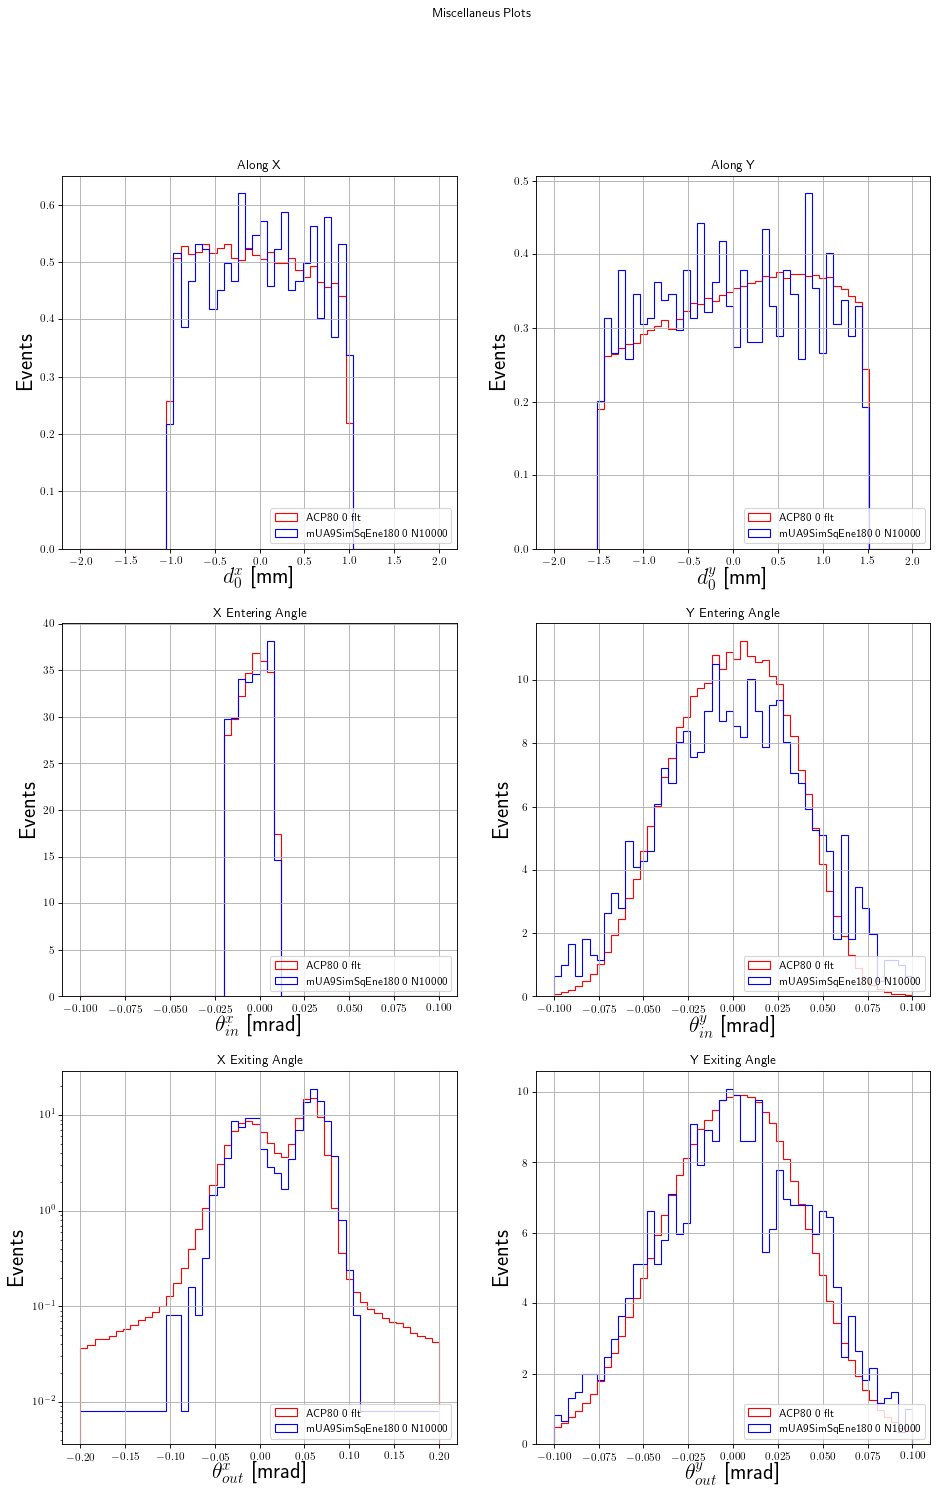

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(7*2, 7*3),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Miscellaneus Plots")

axes[0][0].set_title("Along X")
axes[0][1].set_title("Along Y")
axes[1][0].set_title("X Entering Angle")
axes[1][1].set_title("Y Entering Angle")
axes[2][0].set_title("X Exiting Angle")
axes[2][1].set_title("Y Exiting Angle")

for i in range(nds):
    plot1DNorm(axes[0][0],datasets[i]["d0_x"],inFileLabels[i],d0xL,"Events",
           False,colors[i],nBd0F,d0xR)
    plot1DNorm(axes[0][1],datasets[i]["d0_y"],inFileLabels[i],d0yL,"Events",
       False,colors[i],nBd0F,d0yR)
    plot1DNorm(axes[1][0],datasets[i]["thetaIn_x"],inFileLabels[i],tInXL,"Events",
       False,colors[i],nBthF,tInXR)
    plot1DNorm(axes[1][1],datasets[i]["thetaIn_y"],inFileLabels[i],tInYL,"Events",
       False,colors[i],nBthF,tInYR)
    plot1DNorm(axes[2][0],datasets[i]["thetaOut_x"],inFileLabels[i],tOutXL,"Events",
       True,colors[i],nBthF,tOutXR)
    plot1DNorm(axes[2][1],datasets[i]["thetaOut_y"],inFileLabels[i],tOutYL,"Events",
       False,colors[i],nBthF,tOutYR)

plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Now we want to evaluate the efficiency (in terms of number of particles) of the two processes:
    - Channeling (red)
    - Volume Reflection (blue)

4435169
0.001


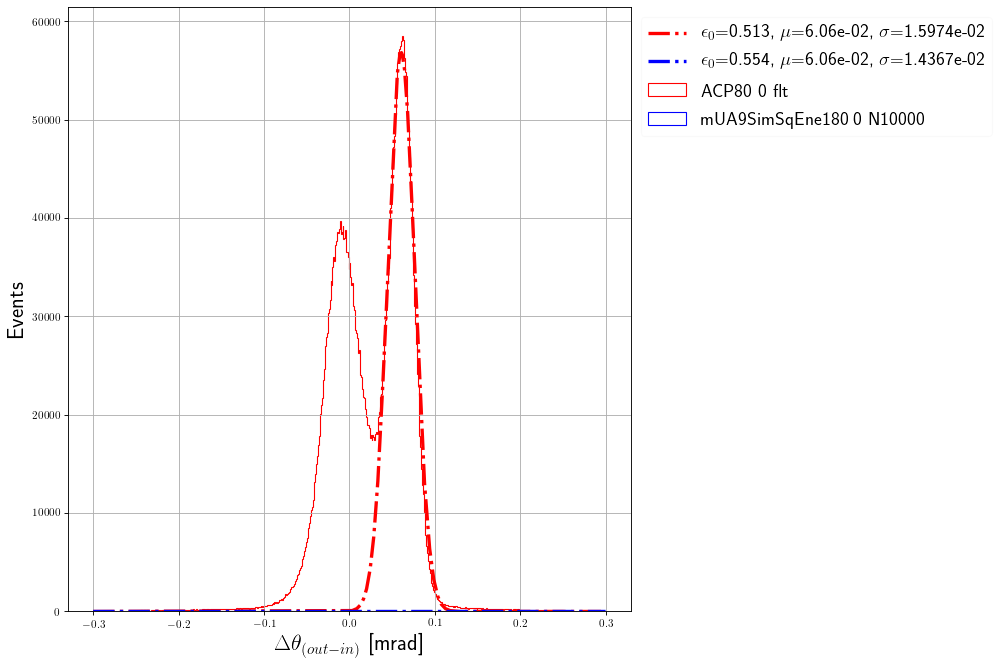

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 144
    # data points      = 40
    # variables        = 3
    chi-square         = 91119187.6
    reduced chi-square = 2462680.75
    Akaike info crit   = 591.551980
    Bayesian info crit = 596.618619
[[Variables]]
    amplitude:  2275.07776 +/- 27.6634562 (1.22%) (init = 1)
    center:     0.06057778 +/- 1.8359e-04 (0.30%) (init = 0)
    sigma:      0.01597371 +/- 2.4145e-04 (1.51%) (init = 1)
    fwhm:       0.03761520 +/- 5.6858e-04 (1.51%) == '2.3548200*sigma'
    height:     56819.9249 +/- 403.512170 (0.71%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.887
    C(amplitude, center) =  0.550
    C(center, sigma)     =  0.531
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 161
    # data points      = 40
    # variables  

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(2*10, 10),dpi=80,facecolor='w', edgecolor='k')

print(datasets[0].shape[0])
commonBinWidth=max(int(0.5*1000./datasets[0].shape[0])/100.,0.001) #0.001
print(commonBinWidth)
for i in range(nds):
    plot1D(ax[0],datasets[i]["deltaTheta"],inFileLabels[i],dtL,"Events",
            False,colors[i],int(0.5/commonBinWidth),[-0.25,0.25])

if True:
    from lmfit.models import GaussianModel
    mods = []
    outs = []
    predictions = []
    efficiencies = []
    effUnc = []
    for i in range(nds):
        mods.append(GaussianModel())
        if i in [0,1]: #[0,1,2,10]:
        #if False:
            data_entries, bins = np.histogram(datasets[i][abs(datasets[i].deltaTheta-0.055)<0.02]["deltaTheta"], bins=int(0.04/commonBinWidth))
            #print(data_entries)
            data_entries, bins = np.histogram(datasets[i][abs(datasets[i].deltaTheta-0.055)<0.02]["deltaTheta"], bins=int(0.04/commonBinWidth))
        else:
            data_entries, bins = np.histogram(datasets[i][abs(datasets[i].deltaTheta)<0.1]["deltaTheta"], bins=int(0.2/commonBinWidth))
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        pars = mods[-1].guess(data_entries, x=data_entries)
        out = mods[-1].fit(data_entries.astype(float), x=binscenters.astype(float))
        outs.append(out)
        predicted = outs[-1].eval(x=np.linspace(-.3, .3, 1000))
        predictions.append(predicted)
        efficiencies.append((outs[-1].params['amplitude'].value)/commonBinWidth/(len(datasets[i]["deltaTheta"])))
        #effUnc.append((outs[-1].params['amplitude'].stderr)/commonBinWidth/(len(datasets[i]["deltaTheta"])))
        ax[0].plot(np.linspace(-.3, .3, 1000), predictions[-1], color=colors[i], linestyle='-.', 
                 label=(r"$\epsilon_{{{}}}$={:.3f}, $\mu$={:.2e}, $\sigma$={:.4e}".format(inFileLabels[i].split(" ")[1],
                                                                                          ((outs[-1].params['amplitude'].value)/commonBinWidth/(len(datasets[i]["deltaTheta"]))), outs[-1].params['center'].value, outs[-1].params['sigma'].value)))
        ax[0].grid(True)
    leg = ax[0].legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=17)
    leg.get_frame().set_alpha(0.1)
    ax[1].remove()
    plt.show()
    fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
    plotId+=1
    for i in range(nds):
        print(outs[i].fit_report())


## Now we want to imitate the famous H8 plot

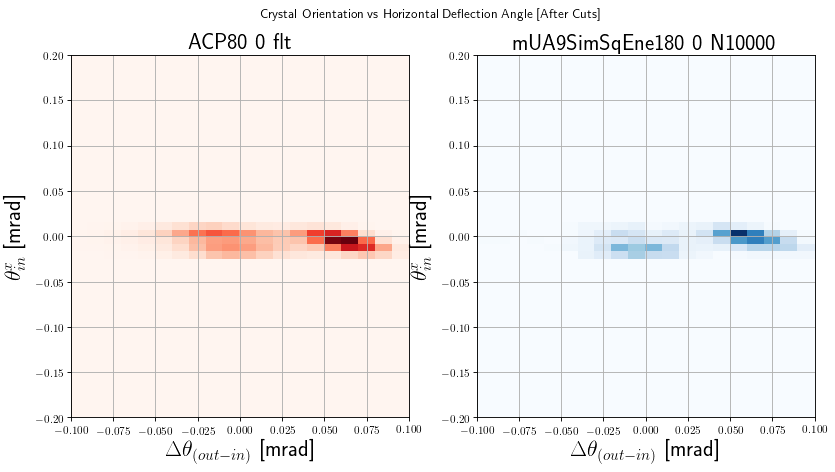

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Crystal Orientation vs Horizontal Deflection Angle [After Cuts]")
plots=[]
for i in range(nds):
    plots.append(
            plot2D(axes[i],datasets[i]["deltaTheta"],datasets[i]["thetaIn_x"]-datasets[i]["deltaGonio"],
                   dtL,tInXL,(nBth,nBthF),[[-.1,.1],tOutXR],colorsP[i])
                )
    plots[-1].set_title(inFileLabels[i],fontsize=20)
    plots[-1].grid(True)

plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Now let's mimic the effect of a magnetic septum that cleans the channeled beam

In [12]:
#mimic the presence of the septum
septumFlag = False
septumAng = 0.03 #I want the particle to be deflected of more than 30urad (2ThetaC, 1/2 ThetaBending)
thetaDeflection = 0.061 #this is the deflection angle
thetaAcceptance = 0.030 #this is an angular acceptance around the deflection angle
if septumFlag:
    for ds in datasets:
        ds = ds[abs(ds["thetaOut_x"]-ds["detlaGonio"]-thetaDeflection)<thetaAcceptance]

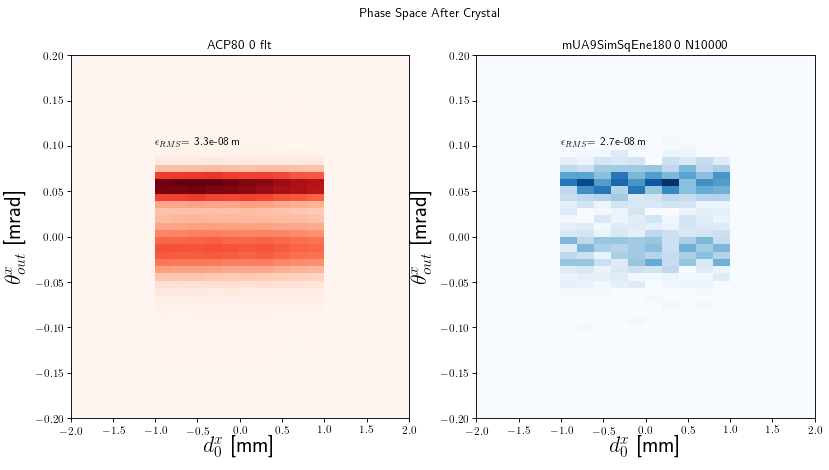

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Phase Space After Crystal")
plots=[]
for i in range(nds):
    plots.append(
                plot2D(axes[i],datasets[i]["d0_x"],datasets[i]["thetaOut_x"]-datasets[i]["deltaGonio"],
                d0xL,tOutXL,(nBd0,nBthF),[d0xR, tOutXR],colorsP[i])
                )
    plots[-1].set_title(inFileLabels[i])
    plots[-1].text(-1.,0.1,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(datasets[i]["d0_x"],datasets[i]["thetaOut_x"]+datasets[i]["gonio_angle"])))

plt.show()

fig.savefig("beams.png")
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

1554


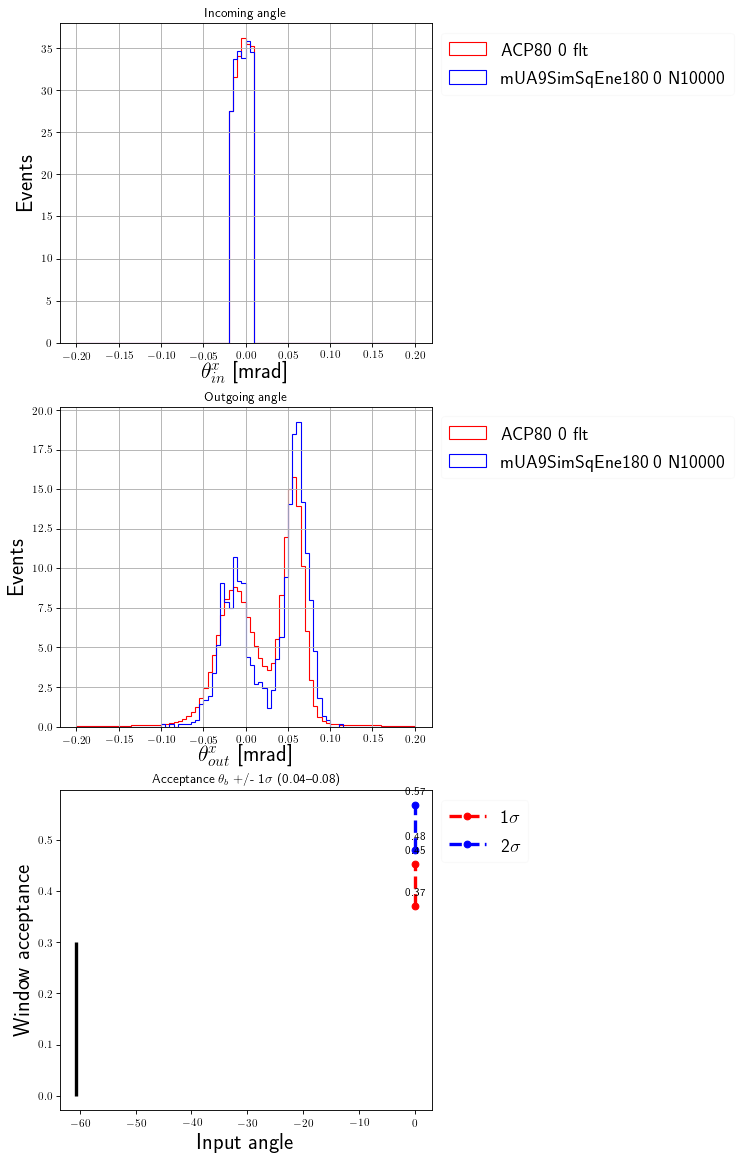

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(6, 6*3),dpi=80,facecolor='w', edgecolor='k')

commonBinWidth=0.005
#commonBinWidth=max(int(0.5*1000./datasets[0].shape[0])/100.,0.01) #0.001

plots=[]
for i in range(nds):
    plots.append(
                plot1DNorm(ax[0],datasets[i]["thetaIn_x"]-datasets[i]["deltaGonio"],inFileLabels[i],tInXL,"Events",
                False,colors[i],int(0.4/commonBinWidth),[-0.2,0.2])
                )
    plots.append(
                plot1DNorm(ax[1],datasets[i]["thetaOut_x"]-datasets[i]["deltaGonio"],inFileLabels[i],tOutXL,"Events",
                False,colors[i],int(0.4/commonBinWidth),[-0.2,0.2])
                )
#ax[0].set_ylim(0.,70.)
#ax[1].set_ylim(0.,40.)
ax[0].title.set_text('Incoming angle')
ax[0].legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=17)
ax[0].get_legend().get_frame().set_alpha(0.1)
ax[1].title.set_text('Outgoing angle')
ax[1].legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=17)
ax[1].get_legend().get_frame().set_alpha(0.1)
#fig.savefig("plot_{:d}_{:d}.png".format(nds,plotId))
#plotId+=1

#fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6, 6),dpi=80,facecolor='w', edgecolor='k')
print(datasets[1].shape[0])
commonBinWidth=max(int(0.5*1000./datasets[0].shape[0])/100.,0.01) #0.005

outCenter = outs[0].params['center'].value
outMin = outs[0].params['center'].value-outs[0].params['sigma'].value
outMax = outs[0].params['center'].value+outs[0].params['sigma'].value
out2Min = outs[0].params['center'].value-2*outs[0].params['sigma'].value
out2Max = outs[0].params['center'].value+2*outs[0].params['sigma'].value

acceptance1S=[]
acceptance2S=[]
for i in range(nds):
    currDS = datasets[i]
    currDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])>outMin)]
    tmpDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])<outMax)]
    acceptance1S.append(tmpDS.shape[0]/datasets[i].shape[0])
for i in range(nds):
    currDS = datasets[i]
    currDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])>out2Min)]
    tmpDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])<out2Max)]
    acceptance2S.append(tmpDS.shape[0]/datasets[i].shape[0])
    #print("Window acceptance: {:s} {:.2f}".format(inFileLabels[i],acceptance[-1]))
    
xs,y1s = zip(*sorted(zip(angles,acceptance1S)))
xs,y2s = zip(*sorted(zip(angles,acceptance2S)))
ax[2].plot(xs,y1s,'--or',label='1$\sigma$')
ax[2].plot(xs,y2s,'--ob',label='2$\sigma$')
ax[2].title.set_text(r'Acceptance $\theta_b$ +/- 1$\sigma$ ({:.2f}--{:.2f})'.format(outMin,outMax))
ax[2].set_xlabel('Input angle',fontsize='20')
ax[2].set_ylabel('Window acceptance',fontsize='20')
ax[2].vlines(outCenter*-1000,0.0,0.3)
ax[2].legend(loc="best", bbox_to_anchor=(1,1), fontsize=17)
ax[2].get_legend().get_frame().set_alpha(0.1)
for x,y in zip(xs,y1s):
    label = "{:.2f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')
for x,y in zip(xs,y2s):
    label = "{:.2f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')

fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

In [15]:
if False:
    outFile = open('Acceptances.txt','a')
    outFile.write('########################\n')
    xs,y1s,y2s,labels = zip(*sorted(zip(angles,acceptance1S,acceptance2S,inFileLabels)))
    for ix,iy1,iy2,ilab in zip(xs,y1s,y2s,inFileLabels):
        outFile.write("{:d} {:.2f} {:.2f} {:s}\n".format(ix,iy1,iy2,ilab.replace(" ","_")))
    outFile.close()